In [1]:
import networkx as nx
import ast
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
import datetime
import seaborn
import collections
from matplotlib import cm


In [2]:
def weighted_dinetwork_MA_block_level(input_date,input_file_number,pre_threshold = 0):
    
    acc_data_liet_name = []
    tem_dt = input_date
        
    acc_data_liet_name.append(tem_dt.strftime('C:/Users/Qingtao/Downloads/'+'%Y-%m-%d')+'-social-distancing.csv.gz')
    for duration in range(1,input_file_number):
        tem_dt += datetime.timedelta(1)
        acc_data_liet_name.append(tem_dt.strftime('C:/Users/Qingtao/Downloads/'+'%Y-%m-%d')+'-social-distancing.csv.gz')
    print( acc_data_liet_name)

    name_list = [1]*input_file_number
    ma_name_list = [1]*input_file_number
    
    # get the MA data of all files
    for i in range(input_file_number):
        name_list[i] = pd.read_csv(acc_data_liet_name[i], index_col=None, header=0)
        ma_name_list[i] = name_list[i][(name_list[i]['origin_census_block_group'] < 260000000000) & 
                                       (name_list[i]['origin_census_block_group']>250000000000)].reset_index()
    
    # change the data structure to dict
    for i in range(input_file_number):
        ma_name_list[i]['destination_cbgs'] = ma_name_list[i]['destination_cbgs'].apply(ast.literal_eval)

    
    # create the initial combined list
    ma_combined = ma_name_list[0][['origin_census_block_group','destination_cbgs' ]]
    
    # combined all destinations of one same block in a period
    for i in range(1, input_file_number): 
        for j in ma_name_list[i].index:
            # create one more row if the region is new
            if ma_name_list[i]['origin_census_block_group'][j] not in ma_combined['origin_census_block_group'].tolist():
                ma_combined.loc[len(ma_combined.index)]=[ma_name_list[i]['origin_census_block_group'][j],
                                                         ma_name_list[i]['destination_cbgs'][j]]

            # accumulate the new information to the incubent row
            else:
                tem_index = ma_combined[ma_combined['origin_census_block_group'] == 
                                        ma_name_list[i]['origin_census_block_group'][j]].index
                tem_replace =  ma_combined['destination_cbgs'][tem_index[0]]
                ma_combined['destination_cbgs'][tem_index[0]]= collections.Counter(tem_replace) + collections.Counter(ma_name_list[i]['destination_cbgs'][j])
    

    # remove the destinations out of MA
    for i in ma_combined.index:
        remove_list = []
        for j in [z for z in ma_combined['destination_cbgs'][i].keys()]:
            if j[:2] != '25':
                remove_list.append(j)
        for k in remove_list:
            del ma_combined['destination_cbgs'][i][k]
    
    # create the edges-list for the weighted network
    edges_list = []
    for num_index in ma_combined.index:
        edges_list += [(str(ma_combined['origin_census_block_group'][num_index]),i,g) for 
                       i,g in ma_combined['destination_cbgs'][num_index].items()]

    
    print('number of edges; ',len(edges_list))
    # createt tht weight dinetwork
    edges_used = [i for i in edges_list if i[2] >= pre_threshold]
    print('number of used edges; ',len(edges_used))
    G_tem = nx.DiGraph()
    G_tem.add_weighted_edges_from(edges_used)
    
    return (G_tem)


In [3]:
def block_to_town_level_G(G_input,convert_matrix):
    G_input_edgelist = nx.to_pandas_edgelist(G_input)
    G_input_edgelist['stract'] = [ i[:11] for i in G_input_edgelist['source']]
    G_input_edgelist['ttract'] = [ i[:11] for i in G_input_edgelist['target']]
    merge_s = pd.merge(G_input_edgelist,convert_matrix, how='left',left_on=['stract'],right_on=['GEOID10']).dropna()
    merge_s = merge_s.rename(columns={'TOWN_ID':'stown_ID','TOWN2':'stown'})
    merge_s = merge_s.drop(columns=['GEOID10'])
    merge_t = pd.merge(merge_s, convert_matrix, how='left',left_on=['ttract'],right_on=['GEOID10']).dropna()
    merge_t = merge_t.rename(columns={'TOWN_ID':'ttown_ID','TOWN2':'ttown'})
    merge_t = merge_t.drop(columns=['GEOID10'])
    
    tem_len = len(merge_t)
    tem_list = []
    tem_source = merge_t['source'].tolist()
    tem_target = merge_t['target'].tolist()
    tem_weight = merge_t['weight'].tolist()
    for i in range(tem_len):
        if tem_source[i] ==tem_target[i]:
            tem_list.append(tem_weight[i])
        else:
            tem_list.append(0)
    merge_t['intra'] = tem_list 
    tem_list2 = merge_t.groupby(['stown', 'ttown'], as_index=False).agg('sum')
    G_temc = nx.DiGraph()
    for i in range(len(tem_list2)):
        G_temc.add_edge(tem_list2['stown'][i] , tem_list2['ttown'][i], 
                      weight=tem_list2['weight'][i].item(), intra = tem_list2['intra'][i].item())
    return(G_temc)

In [8]:
## set_point
def set_initial_value_t(G_input):
    # in_edges_weights
    nx.set_node_attributes(G_input,0,'inweightt')
    # out_edges_weight
    nx.set_node_attributes(G_input,0,'outweightt')
    # intra_edges_weights between blocks in the same county
    nx.set_node_attributes(G_input,0,'intraweightt')
    # intra_edges_weights in the same block
    nx.set_node_attributes(G_input,0,'intraweightb')
    # (county level)LMRc: self_edges_weights/(self_edges_weights+out_edges_weight)
    nx.set_node_attributes(G_input,0,'LMRt')
    # relative LMRc
    nx.set_node_attributes(G_input,0,'RLMRt')
    # (block level)LMRb: self_edges_weights /(self_edges_weights+out_edges_weight)
    nx.set_node_attributes(G_input,0,'LMRb')
    # relative LMRb
    nx.set_node_attributes(G_input,0,'RLMRb')
    

In [9]:
def update_information_t(G_input):
    self_loop_list = []
    self_loop_weight = []
    noself_loop_list= []
    noself_loop_weight = []
    
    check_list  = list(nx.get_edge_attributes(G_input, 'weight').items())
    check_intra_list = list(nx.get_edge_attributes(G_input, 'intra').values())
    for i in range(len(check_list)):
        j = check_list[i]
        in_node = j[0][1]
        out_node = j[0][0]
        # update the information form edges into the self/in/out weight of each node
        if in_node == out_node:
            self_loop_list.append(j[0])
            self_loop_weight.append(j[1])
            G_input._node[in_node].update({'intraweightt': j[1]})
            G_input._node[in_node].update({'intraweightb': check_intra_list[i]})
        else:
            noself_loop_list.append(j[0])
            noself_loop_weight.append(j[1])
            # update the 
            tem_ori_in = G_input._node[in_node]['inweightt']
            G_input._node[in_node].update({'inweightt': tem_ori_in+j[1]})
            tem_ori_out = G_input._node[out_node]['outweightt']
            G_input._node[out_node].update({'outweightt': tem_ori_out+j[1]})
            
    # calculate LMR_t  
    check_node_list = list(G_input.nodes)
    out_weight_list = nx.get_node_attributes(G_input, 'outweightt')
    self_weight_list = nx.get_node_attributes(G_input, 'intraweightt')
    for i in check_node_list:
        if self_weight_list[i]+out_weight_list[i] == 0:
            G_input._node[i].update({'LMRt': 0})
        else:
            G_input._node[i].update({'LMRt':round(self_weight_list[i]/(self_weight_list[i]+out_weight_list[i]),3)})
    
    # calculate RLMR_c
    LMR_list = list(nx.get_node_attributes(G_input, 'LMRt').items())
    LMR_value_list = list(nx.get_node_attributes(G_input, 'LMRt').values())
    mean_LMR = np.mean(LMR_value_list)
    for i in range(len(LMR_list)):
        j = LMR_list[i]
        G_input._node[j[0]].update({'RLMRt': round(j[1]/mean_LMR,3)})
    
    # calculate LMR_b  
    check_node_list = list(G_input.nodes)
    out_weight_list = nx.get_node_attributes(G_input, 'outweightt')
    self_weight_list = nx.get_node_attributes(G_input, 'intraweightt')
    self_weight_list_b = nx.get_node_attributes(G_input, 'intraweightb')
    for i in check_node_list:
        if self_weight_list[i]+out_weight_list[i] == 0:
            G_input._node[i].update({'LMRt': 0})
        else:
            G_input._node[i].update({'LMRb':round(self_weight_list_b[i]/(self_weight_list[i]+out_weight_list[i]),3)})
    
    # calculate RLMR_b
    LMR_list = list(nx.get_node_attributes(G_input, 'LMRb').items())
    LMR_value_list = list(nx.get_node_attributes(G_input, 'LMRb').values())
    mean_LMR = np.mean(LMR_value_list)
    for i in range(len(LMR_list)):
        j = LMR_list[i]
        G_input._node[j[0]].update({'RLMRb': round(j[1]/mean_LMR,3)})
            
    return(self_loop_list, self_loop_weight, 
           noself_loop_list,noself_loop_weight)

# Auxiliary data

In [7]:
## input the convert matrix
tact_to_town = pd.read_csv('C:/Users/Qingtao/final_project_code/weekly_network/maTractsToTowns.csv')
convert_matrix = tact_to_town[['GEOID10', 'TOWN_ID','TOWN2']]
convert_matrix['GEOID10'] = [str(i) for i in tact_to_town['GEOID10']]

# create the weekly block-level network

In [40]:
### input the start date and the duration
########### example
G_test = weighted_dinetwork_MA_block_level(datetime.datetime(2021, 3, 10), 2)

['C:/Users/Qingtao/Downloads/2021-03-10-social-distancing.csv.gz', 'C:/Users/Qingtao/Downloads/2021-03-11-social-distancing.csv.gz']
number of edges;  252905
number of used edges;  252905


# Convert the weekly block-level network to the weekly town-level network

In [41]:
########### example
Gt_test  = block_to_town_level_G(G_test,convert_matrix)

In [42]:
## initialization 
set_initial_value_t(Gt_test )
# return  self_loop_list, self_loop_weight, noself_loop_list,noself_loop_weight
result_Gt_test=update_information_t(Gt_test)

In [43]:
### visualization
## random select one node and cpature the feature
G_node_information_name = list(Gt_test._node['Boston'].keys())
Gt_test_node_inf_df = pd.DataFrame(columns = ['node']+ G_node_information_name)
for i in list(Gt_test.nodes()):
    input_record = [i]+list(Gt_test._node[i].values())
    Gt_test_node_inf_df.loc[len(Gt_test_node_inf_df)] = input_record
    
    
#### information of Gt_test nodes    
Gt_test_node_inf_df

,node,inweightt,outweightt,intraweightt,intraweightb,LMRt,RLMRt,LMRb,RLMRb
0,Abington,1071,1314,1920,1352,0.594,0.968,0.418,0.906
1,Avon,687,294,282,243,0.490,0.798,0.422,0.914
2,Barnstable,2005,1301,4738,2712,0.785,1.279,0.449,0.973
3,Bedford,995,512,1152,827,0.692,1.127,0.497,1.077
4,Belmont,702,711,1545,1215,0.685,1.116,0.539,1.168
...,...,...,...,...,...,...,...,...,...
308,New Marlborough,15,40,48,44,0.545,0.888,0.500,1.083
309,Wales,55,399,354,329,0.470,0.766,0.437,0.947
310,Chilmark,100,111,171,144,0.606,0.987,0.511,1.107
311,Sheffield,88,76,148,109,0.661,1.077,0.487,1.055


In [47]:
#### adjacency matrix of Gt_test 
Gt_test_edge_inf_df = nx.to_pandas_adjacency(Gt_test, dtype=int)
Gt_test_edge_inf_df

,Abington,Avon,Barnstable,Bedford,Belmont,Beverly,Boston,Bourne,Braintree,Bridgewater,...,Hinsdale,Stockbridge,Northfield,Nahant,Huntington,New Marlborough,Wales,Chilmark,Sheffield,Egremont
Abington,1920,12,6,1,3,1,140,1,75,25,...,0,0,0,0,0,0,0,0,0,0
Avon,4,282,0,0,2,0,25,0,53,3,...,0,0,0,0,0,0,0,0,0,0
Barnstable,0,0,4738,0,0,3,54,73,7,2,...,0,0,0,0,0,0,0,0,0,0
Bedford,1,0,0,1152,7,0,47,0,4,0,...,0,0,0,0,0,0,0,0,0,0
Belmont,0,0,0,12,1545,0,100,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
New Marlborough,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,48,0,0,8,2
Wales,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,354,0,0,0
Chilmark,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,171,0,0
Sheffield,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,4,0,0,148,7


In [48]:
### An example to compare two networks

['C:/Users/Qingtao/Downloads/2021-03-10-social-distancing.csv.gz', 'C:/Users/Qingtao/Downloads/2021-03-11-social-distancing.csv.gz']
number of edges;  252905
number of used edges;  252905
['C:/Users/Qingtao/Downloads/2021-04-15-social-distancing.csv.gz', 'C:/Users/Qingtao/Downloads/2021-04-16-social-distancing.csv.gz']
number of edges;  254677
number of used edges;  254677


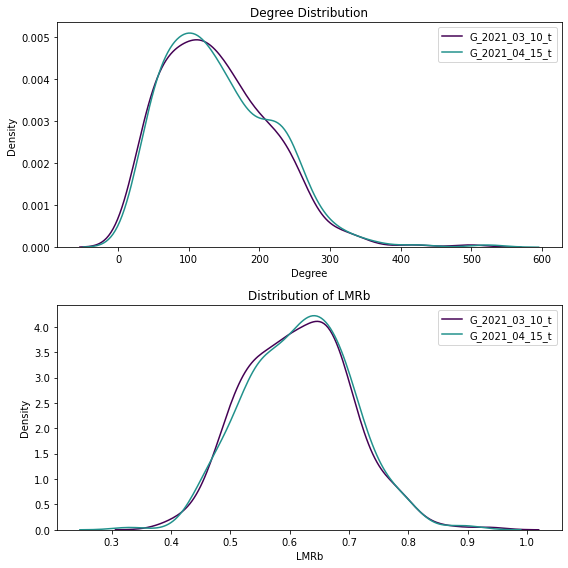

In [36]:
fig, axs = plt.subplots(2,figsize=(8,8))
map_vir = cm.get_cmap(name='viridis')
norm_color = plt.Normalize(0,2)

date_list= [datetime.datetime(2021, 3, 10),datetime.datetime(2021, 4, 15)]
G_name_list = ['G_'+i.strftime('%Y_%m_%d') for i in date_list]

for k in range(len(date_list)):
    G_test = weighted_dinetwork_MA_block_level(date_list[k], 2)
    Gt_test  = block_to_town_level_G(G_test,convert_matrix)
    
    set_inital_value_t(Gt_test )
    result_Gt_test=update_information_t(Gt_test)
    
    G_node_information_name = list(Gt_test._node['Boston'].keys())
    Gt_node_inf_df = pd.DataFrame(columns = ['node']+ G_node_information_name)
    for i in list(Gt_test.nodes()):
        input_record = [i]+list(Gt_test._node[i].values())
        Gt_node_inf_df.loc[len(Gt_node_inf_df)] = input_record

    N_degree_list = []
    for i in Gt_test.nodes():
        N_degree_list = N_degree_list +[Gt_test.degree(i)] 
    seaborn.kdeplot(N_degree_list, ax=axs[0], color = map_vir(norm_color(k)),label = G_name_list[k]+'_t')
    seaborn.kdeplot(list(nx.get_node_attributes(Gt_test, 'LMRt').values()), ax=axs[1], color = map_vir(norm_color(k)),label  =G_name_list[k]+'_t')

axs[0].set_title('Degree Distribution')
axs[0].legend()
#axs[0].set_xscale('log')
axs[0].set_xlabel('Degree')
axs[1].set_title('Distribution of LMRb')
axs[1].legend()
axs[1].set_xlabel('LMRb')
#axs[1].set_xscale('log')
fig.tight_layout()
plt.show()

# Generate all weekly town-level mobility network

In [49]:
### all start date for the Safegraph data
dt = datetime.datetime(2020, 1,6)
end = datetime.datetime(2021, 4, 16)
step = datetime.timedelta(7)

date_list = []
G_name_list = []
while dt < end:
    date_list.append(dt)
    G_name_list.append('G_'+dt.strftime('%Y_%m_%d'))
    dt += step


### the example to generate all weekly block-level mobility network
# for i in data_list:
#     G_tem = weighted_dinetwork_MA_block_level(i, 5)
#     Gt_tem  = block_to_town_level_G(G_tem,convert_matrix)
#     set_initial_value_t(Gt_tem)
#     result_Gt_test=update_information_t(Gt_tem)
#     G_name_list.append(Gt_tem)